# 1) Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


In [2]:
from PIL import Image
from sklearn.preprocessing import Normalizer
import os
import glob
import cv2

# 2) Data Loading

In [3]:
def load_data(path):
    files = glob.glob(path)
    
    col_images = []
    gray_images = []
    labels = []
    
    for file in files:
        data_path = os.path.join(file, '*g')
        subject = glob.glob(data_path)
        label = os.path.basename(file)
        
        
    
        for data in subject:
            labels.append(label)
            img = cv2.imread(data)
            crop_img = img[300:1530, 750:1500]
            img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
            col_images.append(img)
            gray_images.append(gray)
        
    return col_images, gray_images, labels

In [4]:
train_path = 'biometrics/train/*'
test_path = 'biometrics/test/*'

train_col, train_data, train_labels = load_data(train_path)
test_col, test_data, test_labels = load_data(test_path)

# 4) Pre-processing

### 4.1) Data Preparation

In [5]:
def create_templates(datum):
    background = cv2.imread('background.jpg')
    crop_bg = background[300:1530, 750:1500]
    
    bg = cv2.cvtColor(crop_bg, cv2.COLOR_RGB2LAB)
    _, thr = cv2.threshold(bg,90,255,cv2.THRESH_BINARY)
    bg = cv2.cvtColor(thr, cv2.COLOR_LAB2RGB)
    bg = cv2.cvtColor(bg, cv2.COLOR_RGB2GRAY)
    _, thr_bg = cv2.threshold(bg,120,255,cv2.THRESH_BINARY)
    
    template_top_treadmill = thr_bg[690:1100, 55:145]
    
    return template_top_treadmill#, template_marker

In [6]:
def remove_treadmill(template, datum):
    result = cv2.matchTemplate(datum, template, cv2.TM_CCOEFF_NORMED)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

    (startX, startY) = maxLoc
    endX = startX + template.shape[1]
    endY = startY + template.shape[0]

    for y in range(startY, datum.shape[0]):
        for x in range(0, endX):
            datum[y,x] = 255
    for y in range(540, datum.shape[0]):
        for x in range(0, 180):
            datum[y,x] = 255
            
    return datum

In [7]:
def preprocess(data, data_col, TRAIN=True):
    template_top_treadmill = []
    #template_marker = []
    
    data1 = data.copy()
    
    for i, datum, col_img in zip(range(len(data1)), data1, data_col):
        
        img = cv2.cvtColor(col_img, cv2.COLOR_RGB2LAB)
        _, thr = cv2.threshold(img,90,255,cv2.THRESH_BINARY)
        img = cv2.cvtColor(thr, cv2.COLOR_LAB2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thr = cv2.threshold(img,120,255,cv2.THRESH_BINARY)
        
        if i == 0:
            template_top_treadmill = create_templates(thr)
        
        tmp = remove_treadmill(template_top_treadmill, thr)
        
        data1[i] = tmp
        
    return data1

In [8]:
train_data_pr = preprocess(train_data, train_col)
test_data_pr = preprocess(test_data, test_col, False)

### 4.2) Feature Extraction

In [9]:
def find_center(contours):
    cont_lens = [len(i) for i in contours]
    index = np.argmax(cont_lens)
    
    M = cv2.moments(contours[index])
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    
    return [cx, cy]

In [10]:
def generate_contours(data):
    data_contours = [0 for i in range(len(data))]
    centers = [0 for i in range(len(data))]
    l = len(data)
    
    for j, datum in zip(range(l), data):
        blurred = cv2.medianBlur(datum,17)
        pad = cv2.copyMakeBorder(blurred,0,10,0,0,cv2.BORDER_CONSTANT,value=(255,255,255))
        edged = cv2.Canny(pad, 0, 255)
        
        contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #contours_sorted = sorted(contours, key=cv2.contourArea)
        #cont_lens = [len(i) for i in contours]
        #index = np.argmax(cont_lens)
        
        
        combined_contours = np.array([[0,0]]) #np.array(np.squeeze(contours[index]))
        minLen = 500
        for i in contours: 
            i_len = np.shape(i)[0]
            if i_len > minLen :
                combined_contours = np.concatenate((combined_contours, np.squeeze(i)), axis=0)
        
        combined_contours = combined_contours[1:]
        data_contours[j] = combined_contours
        #print(np.shape(data_contours[j]))
        centers[j] = find_center(contours)
        
        #data_contours[j] = remove_zeros(data_contours[j])
        
    return data_contours, centers

In [11]:
def unwrap_silhouette(datum, datum_contours, center, image):
    unwrap = np.array([])
    for point in datum_contours:
        
        unwrap = np.append(unwrap, np.linalg.norm(center - point))
        
        
    unwrap_norm = (unwrap - unwrap.min()) / (unwrap.max() - unwrap.min())
    #print(pd.DataFrame(unwrap).isnull().values.any())
    return down_sample(unwrap), unwrap

In [12]:
def down_sample(unwrap_norm, NUM_SAMPLES = 2000):
    num_points = unwrap_norm.size

    splitter = np.linspace(0, len(unwrap_norm), num=NUM_SAMPLES+1, dtype=int)
    downsampled = np.split(unwrap_norm, splitter[1:])
    final = np.array(list(np.mean(item) for item in downsampled[:-1]))
    
    return final

In [13]:
def get_features(data, contours_set, centers, data_col):
    dataset = [[] for i in range(len(data))]
    dataset_ds = [[] for i in range(len(data))] 
    
    for i, image, datum, contours, center in zip(range(len(data)), data_col, data, contours_set, centers):
        
        dataset_ds[i], dataset[i] = unwrap_silhouette(datum, contours, center, image)
        
    return dataset, dataset_ds

In [14]:
train_contours, train_centers = generate_contours(train_data_pr)
test_contours, test_centers = generate_contours(test_data_pr)

In [15]:
not_down_sampled_train, train_features = get_features(train_data_pr, train_contours, train_centers, train_col)
not_down_samples_test, test_features = get_features(test_data_pr, test_contours, test_centers, test_col)

In [16]:
normalizer = Normalizer().fit(train_features) 
train_features = normalizer.transform(train_features)
test_features = normalizer.transform(test_features)

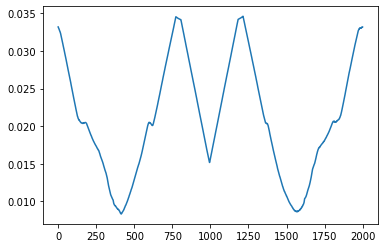

In [17]:
plt.plot(train_features[68])

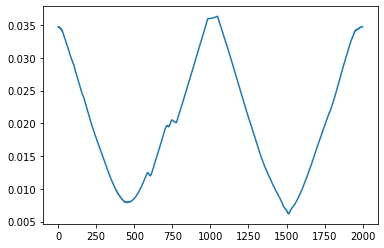

In [18]:
plt.plot(train_features[69])

# 5) Histogram of Distances

In [19]:
train_front = []
train_side = []
test_front = []
test_side = []

train_front_labels = []
test_front_labels = []
train_side_labels = []
test_side_labels = []

# Generating front and side profile datasets
for i in range(len(train_features)):
        if i%2==0:
            train_front.append(train_features[i])
            train_front_labels.append(train_labels[i])
        else:
            train_side.append(train_features[i])
            train_side_labels.append(train_labels[i])
            
for i in range(len(test_features)):
        if i%2==0:
            test_side.append(test_features[i])
            test_side_labels.append(test_labels[i])
        else:
            test_front.append(test_features[i])
            test_front_labels.append(test_labels[i])

In [20]:
# Creating dataframes for use in SVM and filling in any NaN values by using average of element 
# before and after the NaN value

train_final = pd.DataFrame(train_features)
train_final = (train_final.ffill()+train_final.bfill())/2

test_final = pd.DataFrame(test_features)
test_final = (test_final.ffill()+test_final.bfill())/2

train_final_side = pd.DataFrame(train_side)
train_final_side = (train_final_side.ffill()+train_final_side.bfill())/2

train_final_front = pd.DataFrame(train_front)
train_final_front = (train_final_front.ffill()+train_final_front.bfill())/2

test_final_side = pd.DataFrame(test_side)
test_final_side = (test_final_side.ffill()+test_final_side.bfill())/2

test_final_front = pd.DataFrame(test_front)
test_final_front = (test_final_front.ffill()+test_final_front.bfill())/2

In [21]:
distances_side = []
distances_front = []

for i in range(len(train_features)):
    for j in range(len(train_features)):
        if i%2!=0 and j%2!=0:
            distances_side.append(np.linalg.norm(train_features[i] - train_features[j]))
        elif i%2==0 and j%2==0:
            
            distances_front.append(np.linalg.norm(train_features[i] - train_features[j]))

(array([344., 362., 166., 134., 168.,  16.,  30., 202., 436.,  78.]),
 array([0.        , 0.08391215, 0.1678243 , 0.25173645, 0.3356486 ,
        0.41956076, 0.50347291, 0.58738506, 0.67129721, 0.75520936,
        0.83912151]),
 <BarContainer object of 10 artists>)

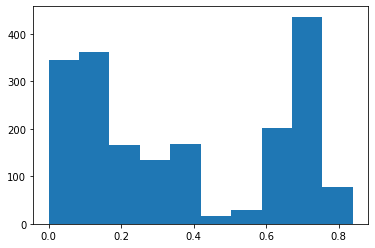

In [22]:
plt.hist(distances_front)

(array([ 50., 412., 630., 464., 194.,  86.,  30.,  48.,  14.,   8.]),
 array([0.        , 0.02120441, 0.04240881, 0.06361322, 0.08481762,
        0.10602203, 0.12722643, 0.14843084, 0.16963524, 0.19083965,
        0.21204406]),
 <BarContainer object of 10 artists>)

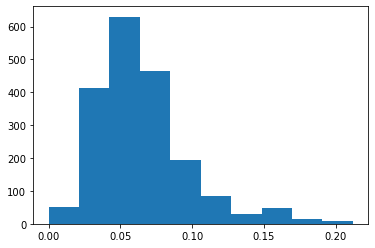

In [23]:
plt.hist(distances_side)

In [24]:
combined_distances = np.append(distances_front, distances_side)

(array([1888.,  728.,  192.,  134.,  168.,   16.,   30.,  202.,  436.,
          78.]),
 array([0.        , 0.08391215, 0.1678243 , 0.25173645, 0.3356486 ,
        0.41956076, 0.50347291, 0.58738506, 0.67129721, 0.75520936,
        0.83912151]),
 <BarContainer object of 10 artists>)

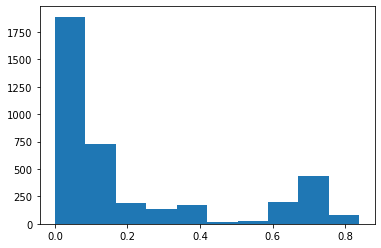

In [25]:
plt.hist(combined_distances)

# 6) Subject Recognition

### 6.1) SVM All Profiles

In [26]:
from sklearn import svm
from sklearn.metrics import accuracy_score

lin_clf = svm.LinearSVC()
lin_clf.fit(train_final, train_labels)
pred = lin_clf.predict(test_final)

accuracy_score(test_labels, pred)

0.09090909090909091

### 6.2) KNN All Profiles

In [27]:
predictions = []

for i in range(len(test_final)):
    distances = []
    
    for j in range(len(train_final)):
        distances.append(np.linalg.norm(test_final.loc[i] - train_final.loc[j]))
    
    index_min = np.argmin(distances)
    predictions.append(train_labels[index_min])
    
accuracy_score(test_labels, predictions)

0.2727272727272727

### 6.3) SVM Side Profiles

In [28]:
lin_clf = svm.LinearSVC()
lin_clf.fit(train_final_side, train_side_labels)
pred = lin_clf.predict(test_final_side)
accuracy_score(test_side_labels, pred)

0.36363636363636365

### 6.4) KNN Side Profiles

In [29]:
predictions = []

for i in range(len(test_final_side)):
    distances = []
    
    for j in range(len(train_final_side)):
        distances.append(np.linalg.norm(test_final_side.loc[i] - train_final_side.loc[j]))
    
    index_min = np.argmin(distances)
    predictions.append(train_side_labels[index_min])
    
accuracy_score(test_side_labels, predictions)

0.45454545454545453

### 6.5) SVM Front Profiles

In [30]:
lin_clf = svm.LinearSVC()
lin_clf.fit(train_final_front, train_front_labels)
pred = lin_clf.predict(test_final_front)
accuracy_score(test_front_labels, pred)

0.0

### 6.6) KNN Front Profiles

In [31]:
predictions = []

for i in range(len(test_final_front)):
    distances = []
    
    for j in range(len(train_final_front)):
        distances.append(np.linalg.norm(test_final_front.loc[i] - train_final_front.loc[j]))
    
    index_min = np.argmin(distances)
    predictions.append(train_front_labels[index_min])
    
accuracy_score(test_front_labels, predictions)

0.09090909090909091

### 6.7) SVM x PCA All Profiles

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(train_final)

PCA(n_components=50)

In [33]:
train_pca = pca.transform(train_final)

In [34]:
test_pca = pca.transform(test_final)

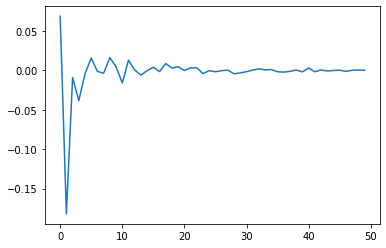

In [35]:
plt.plot(train_pca[68])

In [36]:
lin_clf = svm.LinearSVC()
lin_clf.fit(train_pca, train_labels)
pred = lin_clf.predict(test_pca)

accuracy_score(test_labels, pred)

0.09090909090909091

### 6.8) KNN x PCA All Profiles

In [37]:
predictions = []

for i in range(len(test_pca)):
    distances = []
    
    for j in range(len(train_pca)):
        distances.append(np.linalg.norm(test_pca[i] - train_pca[j]))
    
    index_min = np.argmin(distances)
    predictions.append(train_labels[index_min])
    
accuracy_score(test_labels, predictions)

0.2727272727272727

# 7) Subject Verification

In [38]:
threshold = 0
fa_rates = []
fr_rates = []
thresholds = []

# Test set contains individuals that are ALL in the training set, therefore False Acceptance Rate is always 0?

for threshold in range(0, 75):
    verifications = 0
    fr_count = 0
    fa_count = 0

    for i in range(len(test_final)):
        distances = []

        for j in range(len(train_final)):
            distances.append(np.linalg.norm(test_final.loc[i] - train_final.loc[j]))
        
        for k in range(len(distances)):
            if distances[k] <= threshold * 0.005 and test_labels[i] != train_labels[k]:
                fa_count += 1
            elif distances[k] > threshold * 0.005 and test_labels[i] == train_labels[k]:
                fr_count += 1
                
    fa_rates.append(fa_count / (21 * 88)) # for each verification against existing dataset, can falsely accept 21 imposters, 
    fr_rates.append(fr_count / (1 * 88)) # for each verification, can falsley reject the correct person once
    thresholds.append(threshold * 0.005)
    #print(fa_count)
    #print(fr_count)
    

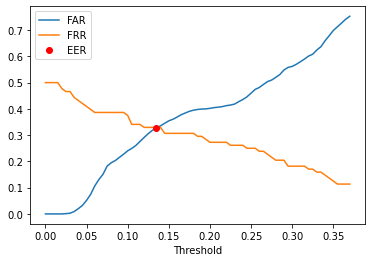

x:  0.135  y:  0.3268398268398268


In [137]:
#plt.axis([0, 1, -0.05, 1])

fig, ax = plt.subplots()

idx = np.argwhere(np.diff(np.sign(np.array(fa_rates) - np.array(fr_rates)))).flatten()

ax.plot(thresholds, fa_rates, label='FAR')
ax.plot(thresholds, fr_rates, label='FRR')
ax.plot(thresholds[idx[0]], fa_rates[idx[0]], 'ro', label='EER')

plt.xlabel('Threshold')
ax.legend(loc='upper left')

plt.show()
print('x: ', thresholds[idx[0]], ' y: ',fa_rates[idx[0]])